In [1]:
import Pkg
Pkg.activate(dirname(Base.current_project())) # activate project
using OrdinaryDiffEq
using Optimization, OptimizationOptimJL
using Statistics
using Plots

  Activating project at `~/Desktop/Jordi/Julia/Julia-intro-for-geoscience-EGU2024`


## Jordi: why I love Julia

- Syntax and expressivity
- Modern and efficient package and environment manager
- Julia is made for science
- Great automatic differentiation (AD) support = fancy Scientific Machine Learning capabilities, mixing differential equations with machine learning
- Huge amount of numerical solvers and tools

# Differential equations in Julia

In this third and last notebook, we are going to briefly introduce some of the packages and capabilities of Julia in order to solve and optimize (i.e. forward and inverse) problems including differential equations. We will focus on a simple ODE to illustrate how this works. 

## Solving differential equations

### Lotka-Volterra equations

The Lotka-Volterra equations are used to describe prey-predator dynamics of biological systems. They look like this:

$$
\begin{array}{lcl}
\frac{dx}{dt} = \alpha x - \beta xy, \\ \\
\frac{dy}{dt} = \gamma xy - \delta y,
\end{array}
$$

where 

- $x$ is the population density of prey (e.g. rabbits)
- $y$ is the population density of predator (e.g. wolves)
- $\frac{dx}{dt}$ and $\frac{dy}{dt}$ represent the instantaneous growth rates of both populations
- $\alpha$, $\beta$, $\gamma$ and $\delta$ are parameters modulating the birth and death rates of each population. 

In Julia, we would write this equation like this, following the standard interface of the popular package `DifferentialEquations.jl`:

In [2]:
function lotka_volterra!(du, u, p, t)
    α, β, γ, δ = p
    du[1] = α*u[1] - β*u[2]*u[1] # dx/dt
    du[2] = γ*u[1]*u[2] - δ*u[2] # dy/dt
end

lotka_volterra! (generic function with 1 method)

In order to easily solve these ODEs, first we need to declare the initial values of our populations and the parameters of the equation:

In [3]:
tspan = (0.0, 20.0) # Time range for the simulation
u₀ = [0.44249296,4.6280594] # Initial values for the x and y populations, respectively
p = [1.3, 0.9, 0.8, 1.8]; # Values for the alpha, beta, gamma and delta parameters, respectively

Then, we can create an `ODEProblem` based on the `lotka_volterra!` function and these parameters, which we can easily solve. In the `solve` function from `DifferentialEquations.jl`, we can specify which solver we'd like to use, or we can let the package decide for us (i.e. using some heuristics). In this notebook, in order to keep dependencies smaller, we just imported `OrdinaryDiffEq.jl`, the ODE subpackage. This means that we need to specify the solver that we want. We can also provide relative and absolute tolerances, and we can decide at which timestep to solve the output of the differential equation. 

In [4]:
prob_lv = ODEProblem(lotka_volterra!, u₀, tspan, p)
solution_lv = solve(prob_lv, Tsit5(), abstol=1e-12, reltol=1e-12, saveat = 0.1);

Now we can plot the `solution` to see how it looks like.

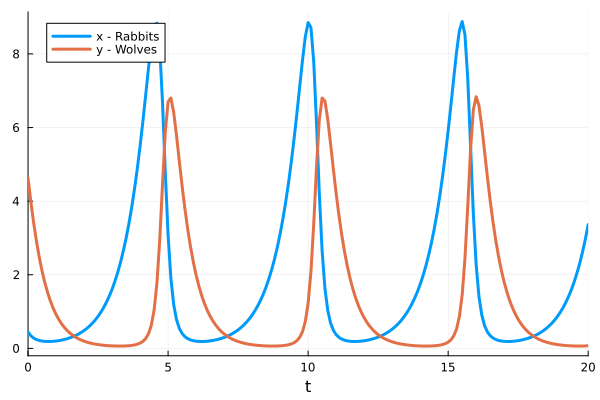

In [5]:
plot(solution_lv, linewidth = 3, label = ["x - Rabbits" "y - Wolves"])

We can see that as the rabbit ($x$) population grows, at some point the wolf ($y$) population grows a lot as a consequence of all the available food. This reaches a tipping point, where the rabbit population is too small for the current wolve population, which sees both populations decrease. 

## Optimization with differential equations

Another very interesting aspect of Julia are its automatic differentiation capabilities, which are great for inverse problems and for machine learning. In order to illustrate this, we'll perform some optimization in the Lotka-Volterra equations, in order to invert some unknown parameters.

For this, we will create an objective function based on the `lotka_volterra!` function, for which we will invert two missing parameters.

In [6]:
function lotka_volterra_inference!(du, u, p, known_params, t)
    β, γ = known_params
    # We invert p[1] and p[2]
    du[1] = p[1]*u[1] - β*u[2]*u[1] # dx/dt
    du[2] = γ*u[1]*u[2] - p[2]*u[2] # dy/dt
end

lotka_volterra_inference! (generic function with 1 method)

In [7]:
function objfun_lv(p, known_params, u₀, tspan, real_solution)
    
    lotka_volterra_closure!(du,u,p,t) = lotka_volterra_inference!(du,u,p, known_params,t)
    prob = ODEProblem(lotka_volterra_closure!, u₀, tspan, p)
    solution = solve(prob, Tsit5(), p=p, abstol=1e-12, reltol=1e-12, saveat = 0.1)
 
    MSE = mean((solution.u[1] .- real_solution.u[1]).^ 2 .+ (solution.u[2] .- real_solution.u[2]).^ 2)

    return MSE
end

objfun_lv (generic function with 1 method)

Once we have the objective function, we can perform an optimization based on it using the `Optimization.jl` package. We'll use forward differentiation with `ForwardDiff.jl`, since we only have 2 parameter to optimize ($\alpha$ the birth rate of rabbits, and $\delta$ the death rate of wolves). For anything larger than 100 parameters (e.g. neural networks) we'd need to use reverse 
differentation. 

In [8]:
tspan = (0.0, 20.0) # Time range for the simulation
u₀ = [0.44249296,4.6280594] # Initial values for the x and y populations, respectively
p = [1.0, 1.0] # initial guess for parameters
known_params = [0.9, 0.8] # Values for the known beta and gamma parameters, respectively
real_solution_lv = solution_lv # we use the previously run simulation as target

objfun_lv_closure(p, known_params) = objfun_lv(p, known_params, u₀, tspan, real_solution_lv)
lotka_volterra_closure!(du,u,p,t) = lotka_volterra_inference!(du,u,p,known_params,t) # closure to expand function signature

optfun_lv = OptimizationFunction(objfun_lv_closure, Optimization.AutoForwardDiff()) 
optprob_lv = OptimizationProblem(optfun_lv, p, known_params) 
optimized_solution_lv = solve(optprob_lv, BFGS())

retcode: Success
u: 2-element Vector{Float64}:
 1.2999999650438399
 1.7999999959435375

If we check the previous values we used in the previous section of this notebook, we can see that we were able to successfully invert the original parameters with high accuracy. 

If we want to know the details of the optimization we can check:

In [9]:
optimized_solution_lv.original

 * Status: success

 * Candidate solution
    Final objective value:     1.734528e-18

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 1.11e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.18e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.23e-11 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 7.12e+06 ≰ 0.0e+00
    |g(x)|                 = 5.68e-10 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    6
    f(x) calls:    21
    ∇f(x) calls:   21


# Your turn

Now that you have seen the basic functioning of the differential equations ecosystem in Julia, it's your turn to put it into practice. We'll focus on the Logistic growth model. It's a simple yet widely used differential equation in ecology and population dynamics. The equation describes the growth of a population in an environment with limited resources and is given by:

$$
\frac{dN}{dt} = r N(1 - \frac{N}{K}), 
$$

where:

- $N$ represents the population size,
- $t$ is time,
- $r$ is the intrinsic growth rate of the population, and
- $K$ is the carrying capacity of the environment.

## Solving the Logistic growth model

Given this initial conditions, parameters, and timespan, how would you implement and solve this equation?

In [10]:
u0 = [10.0]
tspan = (0.0,10.0)
p = (1.5, 60.0) # r and K

(1.5, 60.0)

## Inversion of the Logistic growth model

Following the previous setup, how would you optimize an unknown parameter of the Logistic growth model? You can re-use the previous solution as your target data, and remove one of the 3 parameters (e.g. $r$) as an unknown to be optimized.

# Bonus: the Lorenz equations

An additional exercise would be attempting this with the Lorenz equations:

$$
\begin{array}{lcl}
\frac{dx}{dt} = \sigma(y -x), \\ 
\frac{dy}{dt} = x(\rho - z) - y, \\ 
\frac{dz}{dt} = xy - \beta z
\end{array}
$$

## Solving the Lorenz equations

Given this initial conditions, parameters, and timespan, how would you implement and solve this equation?

In [11]:
u0 = [1.0,0.0,0.0]
tspan = (0.0,100.0)
p = (10.0,28.0,8/3)

(10.0, 28.0, 2.6666666666666665)

## Inversion of the Lorenz equations

Following the previous setup, how would you optimize an unknown parameter of the Lorenz equation? You can re-use the previous solution as your target data, and remove one of the 3 parameters (i.e. $\sigma$, $\rho$ or $\beta$) as an unknown to be optimized.

However, due to the chaotic nature of the Lorenz equations, we have to be careful with which parameter we try to invert, since the solutions might be highly sensitive to slight variations of some of them.